# Example 9: Robust Controlled Invariance or Constrained Robust LQR

In [1]:
import numpy as np
import pypolycontain as pp
import pydrake.solvers.mathematicalprogram as MP
import pydrake.solvers.gurobi as Gurobi_drake
# use Gurobi solver
global gurobi_solver, license
gurobi_solver=Gurobi_drake.GurobiSolver()
license = gurobi_solver.AcquireLicense()
np.random.seed(0)

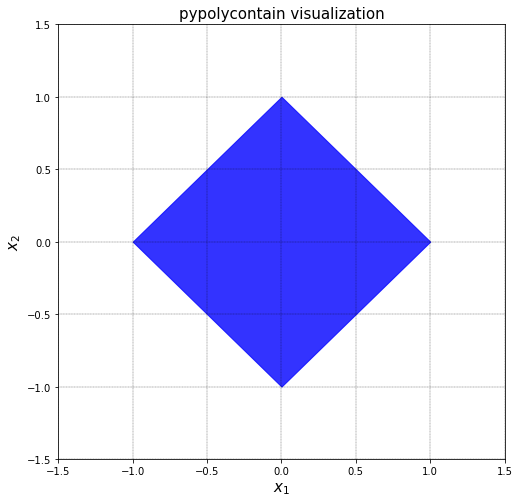

In [2]:
n=2
A=np.eye(n)+np.random.randint(-5,5,size=(n,n))*1/10
A=np.eye(n)+np.random.randint(-5,5,size=(n,n))*1/10

dt=0.01
A=np.array([[1,dt],[0,1+1*dt]])
B=np.array([[dt**2/2,dt]]).reshape(2,1)
W=pp.zonotope(x=np.zeros((n,1)),G=np.array([[1,-1],[1,1]])*0.25*dt)
# X=pp.zonotope(x=np.zeros((n,1)),G=np.array([[1,0],[-0.5,1]]) ,color='cyan')
H=np.array([[-1,1],\
           [1,-1],\
           [-1,-1],[1,1]]).reshape(4,2)
h=np.array([1,1,1,1]).reshape(4,1)
X=pp.H_polytope(H,h,color='blue')
U=pp.zonotope(x=np.zeros((1,1)),G=np.eye(1)*20)
# Cost
Q=np.eye(n)
R=np.eye(1)*10000
pp.visualize([X])

sucsess
alpha was 0.9366234521326345


/home/sadra/Dropbox (MIT)/pypolycontain/pypolycontain/conversions.py:164: UserWarning: Zonotope Vertex Enumeration:                       The number of generators 13 is very large.                       Resorting to ray shooting
  warnings.warn('Zonotope Vertex Enumeration: \


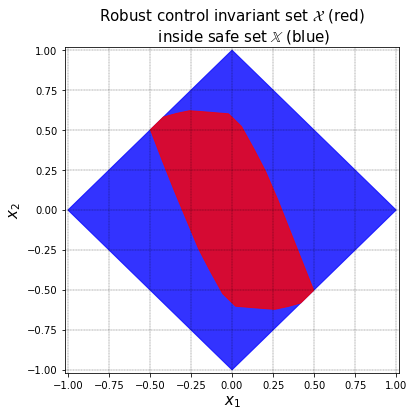

In [3]:
prog=MP.MathematicalProgram()
n,m=A.shape[0],B.shape[1]
q=13
program = MP.MathematicalProgram()
phi=program.NewContinuousVariables(n,q,'phi')
theta=program.NewContinuousVariables(m,q,'theta')
alpha=program.NewContinuousVariables(1,'alpha')
program.AddBoundingBoxConstraint(0,1,alpha)
program.AddQuadraticCost(np.trace( np.linalg.multi_dot([phi.T,Q,phi])   ))
program.AddQuadraticCost(np.trace( np.linalg.multi_dot([theta.T,R,theta])   ))
K=np.hstack(( (np.dot(A,phi) + np.dot(B,theta))[:,n:] , W.G ))
program.AddLinearConstraint (  np.equal(K, phi, dtype='object').flatten() )
inbody=pp.zonotope(x=np.zeros((n,1)), G=(np.dot(A,phi)+np.dot(B,theta))[:,0:n])
_W=pp.to_AH_polytope(W)
_W.P.h=_W.P.h*alpha
_X=pp.to_AH_polytope(X)
_X.P.h=_X.P.h*(1-alpha)
_U=pp.to_AH_polytope(U)
_U.P.h=_U.P.h*(1-alpha)
pp.subset(program, inbody,circumbody=_W)
pp.subset(program, pp.zonotope(x=np.zeros((2,1)),G=phi),circumbody=_X)
pp.subset(program, pp.zonotope(x=np.zeros((1,1)),G=theta),circumbody=_U)
result=gurobi_solver.Solve(program,None,None)
if result.is_success():
    print("sucsess")
    alpha_n=result.GetSolution(alpha)
    phi_n= result.GetSolution(phi)
    theta_n= result.GetSolution(theta)
    Omega=pp.zonotope(x=np.zeros((2,1)),G=phi_n/(1-alpha_n),color='red')
    pp.visualize([X,Omega],title='Robust control invariant set $\mathcal{X}$ (red) \n \
    inside safe set $\mathbb{X}$ (blue)',figsize=(6,6),a=0.02)
    print("alpha was",alpha_n[0])
else:
    print("failure")

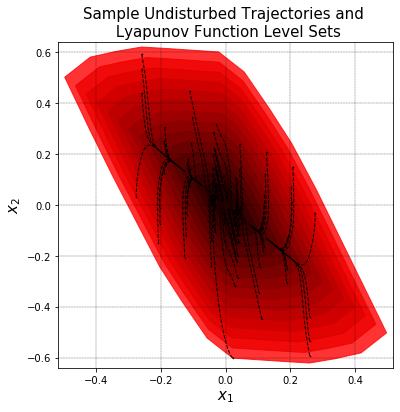

In [4]:
def control(phi,theta,x):
    program = MP.MathematicalProgram()
    n,q=phi.shape
    assert n,q==theta.shape
    zeta=program.NewContinuousVariables(q,1,'zeta')
    zeta_inf=program.NewContinuousVariables(1,1,'zeta_phi')
    program.AddLinearConstraint( np.equal(x, np.dot(phi,zeta), dtype='object').flatten() )
    program.AddLinearConstraint( np.greater_equal( zeta_inf, zeta, dtype='object').flatten() )  
    program.AddLinearConstraint( np.greater_equal( zeta_inf, -zeta, dtype='object').flatten() )
    program.AddLinearCost( np.array([1]),np.array([0]), zeta_inf )   
    result=gurobi_solver.Solve(program,None,None)
    if result.is_success():
#         print("sucsess")
        zeta_n=result.GetSolution(zeta)
#         print(  result.GetSolution(zeta_inf)[0] )
        return np.dot(theta,zeta_n).reshape(1,1),result.GetSolution(zeta_inf)[0]

    
import matplotlib.pyplot as plt

fig,ax=plt.subplots()
# pp.visualize([pp.zonotope(G=V[t]*phi_n,color=(1-0.8*V[t]/V[0],0,0)) \
#               for t in range(T)],ax=ax,fig=fig,\
#              title=r'Sample Trajectory and Lyapunov Function Level Sets',a=0.1)
pp.visualize([pp.zonotope(G=p/15*phi_n/(1-alpha_n),color=(1*p/15,0,0)) \
              for p in range(15,1,-1)],ax=ax,fig=fig,\
             title='Sample Undisturbed Trajectories and \n Lyapunov Function Level Sets',a=0.02)
x0=pp.vcube(q)
fig.set_size_inches(6,6)
N=101
for i in range(N):
    x={}
    u={}
    V={}
    T=40
    zeta=2*(np.random.random(size=(q,1))-0.5)
    zeta=x0[int(i*len(x0)/N),:].reshape(q,1)
    x[0]=np.dot(phi_n/(1-alpha_n),  zeta/max(np.abs(zeta)))
    for t in range(T):
        u[t],V[t]=control(phi_n,theta_n,x[t])
        x[t+1]=np.dot(A,x[t])+np.dot(B,u[t])
#     ax.plot([x[t][0,0] for t in range(T+1)],[x[t][1,0] for t in range(T+1)],'*',color='cyan')
    ax.plot([x[t][0,0] for t in range(1)],[x[t][1,0] for t in range(1)],'*',color='black',MarkerSize=1)
    ax.plot([x[t][0,0] for t in range(T+1)],[x[t][1,0] for t in range(T+1)],'--',color='black',Linewidth=1)

In [10]:
K=np.dot( theta_n, np.linalg.pinv(phi_n)  )

In [16]:
A_cl=A+B@K
np.linalg.eigvals(A_cl)

array([0.98768713, 0.90900118])

In [18]:
K@phi_n-theta_n

array([[ 0.19712037, -0.19475627,  0.09975514, -0.10199905,  0.01056548,
        -0.02595605, -0.04187009, -0.02414759, -0.06270881,  0.05449374,
        -0.13783213,  0.1248632 , -0.20471651]])